In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point, Polygon, LineString
import requests
import os
import warnings
from tqdm import tqdm
warnings.filterwarnings('ignore')
from matplotlib import pyplot as plt
from shapely.geometry import Point, LineString

## 1.County-level All Trips

In [2]:
root = '/Users/ryan/Documents/01.Research Projects/18.NYC Congestion Pricing/'
all_trips = pd.read_csv(root + '1.Replica Data Processing/(1226) County level all trips v3.csv',dtype={'origin_county':'str','destination_county':'str'})

In [3]:
print(len(all_trips))
print('Number of all trips:',all_trips['Trip_num'].sum())
print('Number of trips to CRZ:' ,all_trips[(all_trips['O_CRZ']!=1) & (all_trips['D_CRZ']==1)]['Trip_num'].sum())
print('Proportion:',all_trips[(all_trips['O_CRZ']!=1) & (all_trips['D_CRZ']==1)]['Trip_num'].sum()/all_trips['Trip_num'].sum())
all_trips.columns

14841
Number of all trips: 70864699
Number of trips to CRZ: 2018456
Proportion: 0.028483236766447


Index(['origin_county', 'destination_county', 'O_CRZ', 'D_CRZ', 'Pop_group',
       'Trip_purpose', 'Time_period', 'Trip_num', 'Pro_PRIVATE_AUTO',
       'Pro_PUBLIC_TRANSIT', 'Pro_ON_DEMAND_AUTO', 'Pro_BIKING', 'Pro_WALKING',
       'Pro_CARPOOL', 'Dur_PRIVATE_AUTO', 'Dur_PUBLIC_TRANSIT',
       'Dur_ON_DEMAND_AUTO', 'Dur_BIKING', 'Dur_WALKING', 'Dur_CARPOOL',
       'Access_time', 'Egress_time', 'In_vehicle_time', 'Num_transfer',
       'Cost_PRIVATE_AUTO', 'Cost_PUBLIC_TRANSIT', 'Cost_ON_DEMAND_AUTO',
       'Cost_BIKING', 'Cost_WALKING', 'Cost_CARPOOL'],
      dtype='object')

In [4]:
aa = all_trips.groupby('Trip_purpose')['Trip_num'].sum().reset_index()
aa['Proportion'] = aa['Trip_num']/aa['Trip_num'].sum()
aa

,Trip_purpose,Trip_num,Proportion
0,Commute,33075288,0.466739
1,Other,37789411,0.533261


In [5]:
marginal_trips = pd.read_csv(root + '1.Replica Data Processing/(1226) Meta data.csv',dtype={'origin_county':'str'})
assert all_trips['Trip_num'].sum() - marginal_trips['Trip_num_inCSA'].sum() == 0

In [6]:
marginal_trips.head()

,origin_county,O_CRZ,Pop_group,Trip_purpose,Time_period,Trip_num_Total,Trip_num_inCSA,Trip_num_outsideCSA,Num_Residents
0,09005,False,Senior,Other,Overnight,8514,8257,257,41678
1,34025,False,NotLowIncome,Other,Peak,732529,729986,2543,308764
2,36103,False,Senior,Commute,Peak,185768,185179,589,274322
3,36061,False,Senior,Other,Peak,97379,96832,547,296849
4,34039,False,Student,Other,Overnight,15664,15576,88,142989


In [7]:
all_trips.head()

,origin_county,destination_county,O_CRZ,D_CRZ,Pop_group,Trip_purpose,Time_period,Trip_num,Pro_PRIVATE_AUTO,Pro_PUBLIC_TRANSIT,...,Access_time,Egress_time,In_vehicle_time,Num_transfer,Cost_PRIVATE_AUTO,Cost_PUBLIC_TRANSIT,Cost_ON_DEMAND_AUTO,Cost_BIKING,Cost_WALKING,Cost_CARPOOL
0,36071,36119,False,False,NotLowIncome,Commute,Peak,5632,0.474432,0.004616,...,17.107248,13.223451,147.938531,2.714286,4.335863,2.90,150.133304,0.0,NaN,0.0
1,34021,34021,False,False,Senior,Other,Peak,59585,0.611261,0.000302,...,6.992029,9.103683,13.904289,0.153846,0.352198,1.45,19.081518,0.0,0.0,0.0
2,09009,09001,False,False,Student,Other,Overnight,1532,0.651436,0.002611,...,10.392713,14.064726,78.292560,1.333333,1.693988,2.90,66.910350,0.0,0.0,0.0
3,36085,34035,False,False,Senior,Other,Overnight,67,0.835821,0.000000,...,NaN,NaN,NaN,NaN,4.565892,NaN,NaN,NaN,NaN,0.0
4,36085,36103,False,False,Senior,Commute,Peak,104,0.692308,0.038462,...,3.021169,18.287563,168.941268,2.750000,8.529235,1.45,169.808051,NaN,NaN,0.0


In [8]:
Counties = gpd.read_file(root+'0.Geographic Boundary/For New Study Area/MSA_counties.shp')
Counties['lng'] = Counties.geometry.centroid.x
Counties['lat'] = Counties.geometry.centroid.y

In [9]:
Counties['STATEFP'].unique()

array(['34', '36', '09', '42'], dtype=object)

## 2. CBG-level trip OD pairs

In [10]:
data = pd.read_csv(root + '1.Replica Data Processing/(1226) OD level data - more than 5 trips.csv',
                   dtype={'origin_bgrp':'str','destination_bgrp':'str'})

In [11]:
NY_CBG_2019 = gpd.read_file(root+'0.Geographic Boundary/tl_2019_36_bg/tl_2019_36_bg.shp')
NY_CBG_2021 = gpd.read_file(root+'0.Geographic Boundary/tl_2021_36_bg/tl_2021_36_bg.shp')
CRZ_2020 = gpd.read_file(root+'0.Geographic Boundary/NYC Congestion Relief Zone.shp')
CRZ_onePolygon = gpd.read_file(root+'0.Geographic Boundary/NYC Congestion Relief Zone (One Polygon).shp')

In [12]:
# This proves that Replica's data uses 2010 CBG GEOID
aa = data[data['origin_bgrp'].map(lambda x:x[:2])=='36']
print(len(aa))
print(aa['origin_bgrp'].isin(NY_CBG_2019['GEOID']).sum())
print(aa['origin_bgrp'].isin(NY_CBG_2021['GEOID']).sum())

1370442
1370442
1171060


In [13]:
# This proves that NYC Congestion Relief Zone.shp uses 2020 CBG GEOID
print(len(CRZ_2020['GEOID'].unique()))
print(CRZ_2020['GEOID'].isin(NY_CBG_2019['GEOID']).sum())
print(CRZ_2020['GEOID'].isin(NY_CBG_2021['GEOID']).sum())

520
408
520


In [14]:
# Get a list of 2010 CBG GEOID located within CRZ
CRZ = CRZ_onePolygon
CBG = NY_CBG_2019

if CRZ.crs != CBG.crs:
    CRZ = CRZ.to_crs(CBG.crs)

# 2) (Recommended) compute centroids in a projected CRS, then bring back
proj = "EPSG:2263"  # NY State Plane (ft) – good for NYC
CBG_p = CBG.to_crs(proj)
CRZ_p = CRZ.to_crs(proj)

CBG_cent = CBG_p.copy()
CBG_cent["geometry"] = CBG_p.geometry.centroid

# 3) Pick CBGs whose centroid is within the CRZ polygon
mask = CBG_cent.within(CRZ_p.geometry.unary_union)   # or .sjoin below
NY_CBG_in_CRZ = CBG.loc[mask.values].copy()

assert len(NY_CBG_in_CRZ) == NY_CBG_in_CRZ['GEOID'].isin(NY_CBG_2019['GEOID']).sum()
NY_CBG_in_CRZ.to_file(root+'0.Geographic Boundary/NYC Congestion Relief Zone (2010 CBG).shp')

<Axes: >

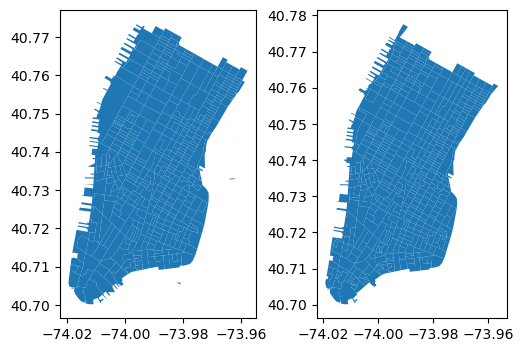

In [15]:
fig,ax = plt.subplots(1,2,figsize=(6,4))
NY_CBG_in_CRZ.plot(ax=ax[0])
CRZ_2020.plot(ax=ax[1])

In [16]:
# This is used to identify Replica's trips to CRZ
cbg_lst = NY_CBG_in_CRZ['GEOID'].unique()
print(len(cbg_lst))
cbg_lst.sort()
# cbg_lst

438


In [17]:
print('Number of agents with 5 or more trips/day:',len(data[data['Trip_num']>=5]))
print('Total number of trips:',data[data['Trip_num']>=5]['Trip_num'].sum())

print('Number of agents with 10 or more trips/day:',len(data[data['Trip_num']>=10]))
print('Total number of trips:',data[data['Trip_num']>=10]['Trip_num'].sum())

print('Number of agents with 50 or more trips/day:',len(data[data['Trip_num']>=50]))
print('Total number of trips:',data[data['Trip_num']>=50]['Trip_num'].sum())

Number of agents with 5 or more trips/day: 2526750
Total number of trips: 38793682
Number of agents with 10 or more trips/day: 1015174
Total number of trips: 29159943
Number of agents with 50 or more trips/day: 111997
Total number of trips: 12508737


### Split Manhattan to CRZ and non-CRZ

In [18]:
data_2020 = data.copy(deep=True)

# ensure strings (so .str slicing works)
ob = data_2020["origin_bgrp"].astype(str)
db = data_2020["destination_bgrp"].astype(str)

o_fips = ob.str.slice(0, 5)
d_fips = db.str.slice(0, 5)

# Manhattan rows only
o_is_manh = o_fips.eq("36061")
d_is_manh = d_fips.eq("36061")

# build suffixes ("-1" / "-0") only where needed
o_suffix = np.where(data_2020["O_CRZ"].to_numpy() == 1, "-1", "-0")
d_suffix = np.where(data_2020["D_CRZ"].to_numpy() == 1, "-1", "-0")

data_2020["origin_county"] = np.where(o_is_manh.to_numpy(), o_fips.to_numpy() + o_suffix, o_fips.to_numpy())
data_2020["destination_county"] = np.where(d_is_manh.to_numpy(), d_fips.to_numpy() + d_suffix, d_fips.to_numpy())

In [19]:
num = data_2020[(data_2020['origin_county']!='36061-1')&(data_2020['destination_county']=='36061-1')]['Trip_num'].sum()
print('Number of total trips:',data_2020['Trip_num'].sum())
print('Number of trips to CRZ:',num)
print('Proportion:',num/data_2020['Trip_num'].sum())

Number of total trips: 38793682
Number of trips to CRZ: 593468
Proportion: 0.015298058070383728


In [20]:
num_dest_counties = len(data_2020['destination_county'].unique())
print('Number of unique destination counties:',num_dest_counties)
print('Number of modes:',6)
print(f'Number of alternatives: {num_dest_counties} x 6 = {num_dest_counties*6}')
print('-----------------')
num_orig_counties = len(data_2020['origin_county'].unique())
print('Number of unique origin counties:',num_orig_counties)
print('Number of population segments:',4)
print('Number of time period:',2)
print('Number of trip purpose:',2)
print(f'Number of markets: {num_orig_counties} x 4 x 2 x 2 = {num_orig_counties*16}')

Number of unique destination counties: 31
Number of modes: 6
Number of alternatives: 31 x 6 = 186
-----------------
Number of unique origin counties: 31
Number of population segments: 4
Number of time period: 2
Number of trip purpose: 2
Number of markets: 31 x 4 x 2 x 2 = 496


### Match 2010 and 2020 CBG

In [21]:
matching_table = pd.read_csv('/Users/ryan/Documents/01.Research Projects/18.NYC Congestion Pricing/0.Geographic Boundary/For New Study Area/cbg_matching_table.csv',
                             dtype={'GEOID_2010':'str','GEOID_2020':'str'})

In [22]:
geoid_lookup = matching_table.drop_duplicates(subset='GEOID_2010').set_index('GEOID_2010')['GEOID_2020'].to_dict()

# Map origin and destination to 2020 GEOIDs
data_2020['origin_bgrp_2020'] = data_2020['origin_bgrp'].map(geoid_lookup)
data_2020['destination_bgrp_2020'] = data_2020['destination_bgrp'].map(geoid_lookup)

# Check for any unmatched values
unmatched_origins = data_2020['origin_bgrp_2020'].isna().sum()
unmatched_destinations = data_2020['destination_bgrp_2020'].isna().sum()

print(f"Unmatched origins: {unmatched_origins} ({unmatched_origins/len(data_2020)*100:.2f}%)")
print(f"Unmatched destinations: {unmatched_destinations} ({unmatched_destinations/len(data_2020)*100:.2f}%)")

Unmatched origins: 0 (0.00%)
Unmatched destinations: 0 (0.00%)


In [23]:
data_2020['Transit_trip'] = data_2020['Pro_PUBLIC_TRANSIT']*data_2020['Trip_num']
for_OTP = data_2020[data_2020['Pro_PUBLIC_TRANSIT']>0]
for_OTP = for_OTP.groupby(['origin_bgrp_2020','destination_bgrp_2020','O_CRZ','D_CRZ'])['Transit_trip'].sum().reset_index()

aa = matching_table.rename(columns={'GEOID_2020':'origin_bgrp_2020','lng_2020':'o_lng','lat_2020':'o_lat'}).drop_duplicates(subset='origin_bgrp_2020')
for_OTP = pd.merge(for_OTP,aa[['origin_bgrp_2020','o_lng','o_lat']],on='origin_bgrp_2020',how='left')
bb = matching_table.rename(columns={'GEOID_2020':'destination_bgrp_2020','lng_2020':'d_lng','lat_2020':'d_lat'}).drop_duplicates(subset='destination_bgrp_2020')
for_OTP = pd.merge(for_OTP,bb[['destination_bgrp_2020','d_lng','d_lat']],on='destination_bgrp_2020',how='left')

ob = for_OTP["origin_bgrp_2020"].astype(str)
db = for_OTP["destination_bgrp_2020"].astype(str)
o_fips = ob.str.slice(0, 5)
d_fips = db.str.slice(0, 5)
# Manhattan rows only
o_is_manh = o_fips.eq("36061")
d_is_manh = d_fips.eq("36061")
# build suffixes ("-1" / "-0") only where needed
o_suffix = np.where(for_OTP["O_CRZ"].to_numpy() == 1, "-1", "-0")
d_suffix = np.where(for_OTP["D_CRZ"].to_numpy() == 1, "-1", "-0")

for_OTP["origin_county"] = np.where(o_is_manh.to_numpy(), o_fips.to_numpy() + o_suffix, o_fips.to_numpy())
for_OTP["destination_county"] = np.where(d_is_manh.to_numpy(), d_fips.to_numpy() + d_suffix, d_fips.to_numpy())

for_OTP = for_OTP[['origin_bgrp_2020','destination_bgrp_2020','origin_county','destination_county','o_lng','o_lat','d_lng','d_lat','Transit_trip']]

In [24]:
for_OTP.head()

,origin_bgrp_2020,destination_bgrp_2020,origin_county,destination_county,o_lng,o_lat,d_lng,d_lat,Transit_trip
0,090010101011,360610092001,09001,36061-1,-73.673092,41.087484,-73.974319,40.752381,6.0
1,090010101011,360610101001,09001,36061-1,-73.673092,41.087484,-73.991541,40.749731,9.0
2,090010101011,360610109001,09001,36061-1,-73.673092,41.087484,-73.989703,40.752250,4.0
3,090010101012,090010102012,09001,09001,-73.692523,41.069582,-73.610819,41.057425,1.0
4,090010101012,090010103002,09001,09001,-73.692523,41.069582,-73.648138,41.034868,1.0


In [25]:
for_OTP.to_csv(root + '1.Replica Data Processing/(1226) OD_matrix_in_OTP.csv',index=False)
data_2020.to_csv(root + '1.Replica Data Processing/(1226) data_2020.csv',index=False)

## 3. Data for County-level model

### 1.Get market-level data
#### Row index: market (o_county * segment)
#### Column index: alternative (d_county * mode)

In [26]:
df = pd.read_csv('/Users/ryan/Documents/01.Research Projects/18.NYC Congestion Pricing/1.Replica Data Processing/(1226) County level all trips v3.csv',
                 dtype={'origin_county':'str','destination_county':'str'})
df = df.sort_values(['origin_county','Pop_group','Trip_purpose','Time_period','destination_county'])
# df['In_vehicle_time'] = df['In_vehicle_time'].map(lambda x: 5 if x<5 else x)
 
def is_crf_o(record):
    if record['origin_county']=='36061':
        if record['O_CRZ']==1:
            return '36061-1'
        else:
            return '36061-0'
    else:
        return record['origin_county']

def is_crf_d(record):
    if record['destination_county']=='36061':
        if record['D_CRZ']==1:
            return '36061-1'
        else:
            return '36061-0'
    else:
        return record['destination_county']

def region_category(record):
    if record in ['36061-1','36061-0']:
        return 'Manhattan'
    elif record in ['36061','36081','36047','36085','36005']:
        return 'NYC'
    elif record[:2] == '36':
        return 'NYS'
    elif record[:2] == '34':
        return 'NJS'
    elif record[:2] == '42':
        return 'PAS'
    elif record[:2] == '09':
        return 'CTS'
    else:
        print('There are some errors')

df['origin_county'] = df.apply(is_crf_o,axis=1)
df['destination_county'] = df.apply(is_crf_d,axis=1)
df['origin_region'] = df['origin_county'].map(region_category)
df['destination_region'] = df['destination_county'].map(region_category)
# Price for carpool is half of the driving
mask = df["Pro_PRIVATE_AUTO"] > 0
df.loc[mask, "Cost_CARPOOL"] = df.loc[mask, "Cost_PRIVATE_AUTO"] / 2

In [27]:
df.groupby('destination_region')['destination_county'].nunique()

destination_region
CTS           3
Manhattan     2
NJS          13
NYC           4
NYS           8
PAS           1
Name: destination_county, dtype: int64

In [28]:
print(len(df['origin_county'].unique()))
print(len(df['destination_county'].unique()))

31
31


### 2.Replace null values for some transit trips

In [29]:
# Filter rows where Pro_PUBLIC_TRANSIT > 0
transit_mask = df['Pro_PUBLIC_TRANSIT'] > 0

# === Part 1: Access_time, Egress_time, In_vehicle_time ===

# Get rows with complete time data to calculate proportions
time_cols = ['Access_time', 'Egress_time', 'In_vehicle_time']
complete_time_mask = transit_mask & df[time_cols].notna().all(axis=1)

# Calculate average proportions from complete data
complete_data = df.loc[complete_time_mask, time_cols + ['Dur_PUBLIC_TRANSIT']]

# Calculate proportion of each component relative to total duration
proportions = {}
for col in time_cols:
    # proportion = component / total_duration
    proportions[col] = (complete_data[col] / complete_data['Dur_PUBLIC_TRANSIT']).mean()

print("Inferred time proportions:")
for col, prop in proportions.items():
    print(f"  {col}: {prop:.4f} ({prop*100:.1f}%)")
print(f"  Sum: {sum(proportions.values()):.4f}")

# Normalize proportions to ensure they sum to 1
total_prop = sum(proportions.values())
proportions = {k: v/total_prop for k, v in proportions.items()}

print("\nNormalized proportions:")
for col, prop in proportions.items():
    print(f"  {col}: {prop:.4f} ({prop*100:.1f}%)")

# Fill missing time values
for col in time_cols:
    # Identify rows needing fill: Pro_PUBLIC_TRANSIT > 0 AND column is null
    fill_mask = transit_mask & df[col].isna()
    
    # Fill with proportion * Dur_PUBLIC_TRANSIT
    df.loc[fill_mask, col] = df.loc[fill_mask, 'Dur_PUBLIC_TRANSIT'] * proportions[col]
    
    print(f"\nFilled {fill_mask.sum()} missing values in {col}")


# === Part 2: Num_transfer ===

# Calculate average Num_transfer per unit duration (or per trip) from complete data
transfer_complete_mask = transit_mask & df['Num_transfer'].notna()

# Option A: Use average Num_transfer directly
avg_num_transfer = df.loc[transfer_complete_mask, 'Num_transfer'].mean()

# Option B: Use Num_transfer per unit of In_vehicle_time (captures trip complexity)
# This assumes longer trips tend to have more transfers
complete_transfer_data = df.loc[transfer_complete_mask & df['In_vehicle_time'].notna()]
if len(complete_transfer_data) > 0:
    transfer_rate = (complete_transfer_data['Num_transfer'] / complete_transfer_data['In_vehicle_time']).replace([np.inf, -np.inf], np.nan).mean()
else:
    transfer_rate = None

print(f"\nNum_transfer inference:")
print(f"  Average Num_transfer: {avg_num_transfer:.3f}")
if transfer_rate:
    print(f"  Transfer rate (per unit In_vehicle_time): {transfer_rate:.6f}")

# Fill missing Num_transfer
fill_transfer_mask = transit_mask & df['Num_transfer'].isna()

# Use transfer rate if available, otherwise use average
if transfer_rate and not np.isnan(transfer_rate):
    # Infer based on In_vehicle_time
    df.loc[fill_transfer_mask, 'Num_transfer'] = (
        df.loc[fill_transfer_mask, 'In_vehicle_time'] * transfer_rate
    ).round()  # Round since transfers are typically integers
    print(f"\nFilled {fill_transfer_mask.sum()} missing Num_transfer values using transfer rate")
else:
    # Fall back to average
    df.loc[fill_transfer_mask, 'Num_transfer'] = round(avg_num_transfer)
    print(f"\nFilled {fill_transfer_mask.sum()} missing Num_transfer values using average")


# === Verification ===
print("\n" + "="*50)
print("Verification:")

# Check remaining nulls
remaining_nulls = df.loc[transit_mask, time_cols + ['Num_transfer']].isna().sum()
print(f"\nRemaining null values (where Pro_PUBLIC_TRANSIT > 0):")
print(remaining_nulls)

# Verify time components sum approximately to duration
df['time_sum'] = df['Access_time'] + df['Egress_time'] + df['In_vehicle_time']
time_diff = (df.loc[transit_mask, 'time_sum'] - df.loc[transit_mask, 'Dur_PUBLIC_TRANSIT']).abs()

# Clean up
df.drop(columns=['time_sum'], inplace=True)

# Check if access_time + egress_time + in_vehicle_time  = transit_duration
assert (df[transit_mask][['Access_time', 'Egress_time', 'In_vehicle_time']].sum(axis=1) - df[transit_mask]['Dur_PUBLIC_TRANSIT']).abs().max() < 0.00001

Inferred time proportions:
  Access_time: 0.1230 (12.3%)
  Egress_time: 0.1398 (14.0%)
  In_vehicle_time: 0.7372 (73.7%)
  Sum: 1.0000

Normalized proportions:
  Access_time: 0.1230 (12.3%)
  Egress_time: 0.1398 (14.0%)
  In_vehicle_time: 0.7372 (73.7%)

Filled 895 missing values in Access_time

Filled 895 missing values in Egress_time

Filled 895 missing values in In_vehicle_time

Num_transfer inference:
  Average Num_transfer: 1.584
  Transfer rate (per unit In_vehicle_time): 0.020132

Filled 895 missing Num_transfer values using transfer rate

Verification:

Remaining null values (where Pro_PUBLIC_TRANSIT > 0):
Access_time        0
Egress_time        0
In_vehicle_time    0
Num_transfer       0
dtype: int64


In [30]:
# Define the normalized proportions (from your output)
proportions = {
    'Access_time': 0.1230,
    'Egress_time': 0.1398,
    'In_vehicle_time': 0.7372
}

# Define the time columns
time_cols = ['Access_time', 'Egress_time', 'In_vehicle_time']

# Find rows where ANY of the time columns has a negative or zero value
# AND Pro_PUBLIC_TRANSIT > 0 (only makes sense for transit users)
transit_mask = df['Pro_PUBLIC_TRANSIT'] > 0
invalid_mask = transit_mask & (
    (df['Access_time'] <= 0) | 
    (df['Egress_time'] <= 0) | 
    (df['Access_time'] == 20) | 
    (df['Egress_time'] == 20) | 
    (df['In_vehicle_time'] <= 0)
)
print(f"Rows with negative or zero values in time columns: {invalid_mask.sum()}")

# For these rows, replace ALL time components using proportions
for col in time_cols:
    df.loc[invalid_mask, col] = df.loc[invalid_mask, 'Dur_PUBLIC_TRANSIT'] * proportions[col]

# Verification
print("\nVerification after replacement:")

# Check for any remaining negative or zero values
remaining_invalid = transit_mask & (
    (df['Access_time'] <= 0) | 
    (df['Egress_time'] <= 0) | 
    (df['Access_time'] == 20) | 
    (df['Egress_time'] == 20) |
    (df['In_vehicle_time'] <= 0)
)
print(f"Remaining rows with negative/zero time values: {remaining_invalid.sum()}")

Rows with negative or zero values in time columns: 1742

Verification after replacement:
Remaining rows with negative/zero time values: 0


### 3.Generate Choice Dataset

In [31]:
id_column = ['origin_county', 'Pop_group', 'Trip_purpose', 'Time_period', 'destination_county', 'origin_region','destination_region', 'mode']
att_column = ['Trip_num','auto_tt','transit_ivt','transit_at','transit_et','transit_nt','non_auto_tt',
              'cost','constant_driving','constant_transit','constant_ondemand','constant_biking','constant_walking','constant_carpool']
modes = ['driving','transit','ondemand','biking','walking','carpool'] 

choice_data = pd.DataFrame()
for i in range(len(df)):
    one_piece = df.iloc[i]
    choice_data_piece = pd.DataFrame(columns=id_column+att_column)
    # ID
    choice_data_piece['mode'] = pd.Series(modes)
    choice_data_piece[id_column[:-1]] = one_piece[id_column[:-1]] 
    # Trip_num
    trip_num = (one_piece['Trip_num']*one_piece[['Pro_PRIVATE_AUTO','Pro_PUBLIC_TRANSIT','Pro_ON_DEMAND_AUTO',
                                      'Pro_BIKING','Pro_WALKING','Pro_CARPOOL']]).map(lambda x:round(x)).values
    choice_data_piece['Trip_num'] = pd.Series(trip_num,index=choice_data_piece.index)
    # auto_tt, transit_ivt, transit_at, transit_et, transit_nt, non_auto_tt, cost
    auto_tt = [one_piece['Dur_PRIVATE_AUTO'],0,one_piece['Dur_ON_DEMAND_AUTO'],0,0,one_piece['Dur_CARPOOL']]
    choice_data_piece['auto_tt'] = pd.Series(auto_tt)
    transit_ivt = [0,one_piece['In_vehicle_time'],0,0,0,0]
    choice_data_piece['transit_ivt'] = pd.Series(transit_ivt)
    transit_at = [0,one_piece['Access_time'],0,0,0,0]
    choice_data_piece['transit_at'] = pd.Series(transit_at)
    transit_et = [0,one_piece['Egress_time'],0,0,0,0]
    choice_data_piece['transit_et'] = pd.Series(transit_et)
    transit_nt = [0,one_piece['Num_transfer'],0,0,0,0]
    choice_data_piece['transit_nt'] = pd.Series(transit_nt)
    non_auto_tt = [0,0,0,one_piece['Dur_BIKING'],one_piece['Dur_WALKING'],0]
    choice_data_piece['non_auto_tt'] = pd.Series(non_auto_tt)
    cost = [one_piece['Cost_PRIVATE_AUTO'],one_piece['Cost_PUBLIC_TRANSIT'],one_piece['Cost_ON_DEMAND_AUTO'],
            0,0,one_piece['Cost_CARPOOL']]
    choice_data_piece['cost'] = pd.Series(cost)
    # constants
    choice_data_piece[['constant_driving','constant_transit','constant_ondemand',
                       'constant_biking','constant_walking','constant_carpool']] = np.eye(6)
    choice_data_piece = choice_data_piece[choice_data_piece['Trip_num']>0].reset_index(drop=True)
    # some OD pairs donot have observed transit time, but this should be fixed in previous cells
    choice_data_piece.dropna(subset=['transit_at','transit_et','transit_nt','transit_ivt'],inplace=True)
    choice_data = pd.concat([choice_data,choice_data_piece])

In [32]:
# Check if there are any trips lost
assert df['Trip_num'].sum() == choice_data.dropna()['Trip_num'].sum()

In [33]:
# Market_id and alternative_id
choice_data['market_id'] = choice_data.groupby(['origin_county','Pop_group','Trip_purpose','Time_period']).ngroup()+1
choice_data['alternative_id'] = choice_data.groupby(['destination_county','mode']).ngroup()+1
choice_data = choice_data.sort_values(['market_id','alternative_id'])

In [34]:
# market share
all_trips = pd.read_csv(root + '1.Replica Data Processing/(1226) Meta data.csv',
                       dtype={'origin_county':'str'})
all_trips['origin_county'] = all_trips.apply(is_crf_o,axis=1)
all_trips.rename(columns={'Trip_num_Total':'All_trips'},inplace=True)
all_trips.drop('O_CRZ',axis=1,inplace=True)
alternative_trips = choice_data.groupby(['origin_county','Pop_group','Trip_purpose','Time_period'])['Trip_num'].sum().reset_index()
all_trips = pd.merge(all_trips,alternative_trips,on=['origin_county','Pop_group','Trip_purpose','Time_period'],how='left')

all_trips['Trip_0'] = all_trips['All_trips'] - all_trips['Trip_num']

choice_data = pd.merge(choice_data,all_trips[['origin_county', 'Pop_group', 'Trip_purpose', 'Time_period',
       'All_trips', 'Trip_0']],on=['origin_county', 'Pop_group', 'Trip_purpose', 'Time_period'],how='left')

choice_data['share'] = choice_data['Trip_num']/choice_data['All_trips']
choice_data['share_0'] = choice_data['Trip_0']/choice_data['All_trips']
choice_data['log_s_s0'] = np.log(choice_data['share']/choice_data['share_0'])

In [35]:
# nest on mode and destination region/county
aa = choice_data.groupby(['market_id','mode'])['share'].sum().reset_index()
diction = dict(zip(zip(aa['market_id'], aa['mode']), aa['share']))
choice_data['log_s_s(mode)'] = choice_data.apply(lambda row: np.log(row['share']/diction[(row['market_id'],row['mode'])]),axis=1)

aa = choice_data.groupby(['market_id','destination_region'])['share'].sum().reset_index()
diction = dict(zip(zip(aa['market_id'], aa['destination_region']), aa['share']))
choice_data['log_s_s(region)'] = choice_data.apply(lambda row: np.log(row['share']/diction[(row['market_id'],row['destination_region'])]),axis=1)

aa = choice_data.groupby(['market_id','destination_county'])['share'].sum().reset_index()
diction = dict(zip(zip(aa['market_id'], aa['destination_county']), aa['share']))
choice_data['log_s_s(county)'] = choice_data.apply(lambda row: np.log(row['share']/diction[(row['market_id'],row['destination_county'])]),axis=1)

In [36]:
aa = choice_data[choice_data['mode']=='driving'].groupby('market_id')['auto_tt'].mean()
bb = choice_data[choice_data['mode']=='ondemand'].groupby('market_id')['auto_tt'].mean()
cc = choice_data[choice_data['mode']=='carpool'].groupby('market_id')['auto_tt'].mean()
auto_tt = pd.concat([aa,bb,cc],axis=1).mean(axis=1)
auto_tt_dict = dict(zip(auto_tt.index,auto_tt.values))
choice_data['iv_auto_tt'] = choice_data.apply(lambda row: ((row['All_trips']-row['Trip_0'])*auto_tt_dict[row['market_id']]- \
                                                           row['Trip_num']*row[['auto_tt','auto_tt','auto_tt']].max()) \
                                                           / (row['All_trips']-row['Trip_0']-row['Trip_num']), axis=1)

In [37]:
aa = choice_data[choice_data['mode']=='transit'].groupby('market_id')['transit_ivt'].mean()
transit_ivt_dict = dict(zip(aa.index,aa.values))
transit_ivt_dict.update({k: 0 for k in auto_tt_dict if k not in transit_ivt_dict})
choice_data['iv_transit_ivt'] = choice_data.apply(lambda row: ((row['All_trips']-row['Trip_0'])*transit_ivt_dict[row['market_id']]- \
                                                           row['Trip_num']*row['transit_ivt']) \
                                                           / (row['All_trips']-row['Trip_0']-row['Trip_num']), axis=1)
#choice_data['iv_transit_ivt'] = choice_data['iv_transit_ivt'].replace(0,999)

In [38]:
aa = choice_data[choice_data['mode']=='walking'].groupby('market_id')['non_auto_tt'].mean()
bb = choice_data[choice_data['mode']=='biking'].groupby('market_id')['non_auto_tt'].mean()
nonauto_tt = pd.concat([aa,bb],axis=1).mean(axis=1)
nonauto_tt_dict = dict(zip(nonauto_tt.index,nonauto_tt.values))
nonauto_tt_dict.update({k: 0 for k in auto_tt_dict if k not in nonauto_tt_dict})
choice_data['iv_nonauto_tt'] = choice_data.apply(lambda row: ((row['All_trips']-row['Trip_0'])*auto_tt_dict[row['market_id']]- \
                                                           row['Trip_num']*row[['non_auto_tt','non_auto_tt']].max()) \
                                                           / (row['All_trips']-row['Trip_0']-row['Trip_num']), axis=1)
#choice_data['iv_nonauto_tt'] = choice_data['iv_nonauto_tt'].replace(0,999)

In [39]:
# Check if there are any trips lost
assert df['Trip_num'].sum() == choice_data['Trip_num'].sum()

In [40]:
county_dummies = pd.get_dummies(choice_data['destination_county'], prefix='County', drop_first=False).astype(int)
choice_data_final = pd.concat([choice_data,county_dummies],axis=1)

In [41]:
choice_data[choice_data['mode']=='transit']['transit_et'].min()

np.float64(0.27964974723842195)

### 4. Get correct travel time and cost

#### Toll for Port Authority crossings: Peak hour $14.75$ USD,  Non-peak hour $12.75$ USD

https://www.northjersey.com/story/news/transportation/2023/01/06/nj-tolls-up-in-2023-for-parkway-turnpike-port-authority-crossings/69781581007/

#### Transit access, egress, waiting, in-vehicle time, and cost from OpenTripPlanner

In [42]:
transit_matrix_peak = pd.read_csv(root+'1.Replica Data Processing/Transit_details_2023_June_8th_9AM.csv')
transit_matrix_nonpeak = pd.read_csv(root+'1.Replica Data Processing/Transit_details_2023_June_8th_2PM.csv')
OD_matrix_old = pd.read_csv(root+'1.Replica Data Processing/OD_matrix_in_OTP.csv',dtype={'origin_bgrp':'str','destination_bgrp':'str','origin_county':'str','destination_county':'str'})
# OD_matrix_new = pd.read_csv(root+'1.Replica Data Processing/(1226) OD_matrix_in_OTP.csv',dtype={'origin_bgrp':'str','destination_bgrp':'str','origin_county':'str','destination_county':'str'})
transit_matrix_peak[['origin_bgrp_2020','destination_bgrp_2020','origin_county','destination_county']] = OD_matrix_old[['origin_bgrp','destination_bgrp','origin_county','destination_county']]
transit_matrix_peak[['transit_at','transit_et','transit_wt','transit_ivt']]/=60
transit_matrix_nonpeak[['origin_bgrp_2020','destination_bgrp_2020','origin_county','destination_county']] = OD_matrix_old[['origin_bgrp','destination_bgrp','origin_county','destination_county']]
transit_matrix_nonpeak[['transit_at','transit_et','transit_wt','transit_ivt']]/=60

# # Swith back to 2010 cbg
# geoid_lookup = matching_table.drop_duplicates(subset='GEOID_2020').set_index('GEOID_2020')['GEOID_2010'].to_dict()
# transit_matrix_peak['origin_bgrp_2020'] = data_2020['origin_bgrp'].map(geoid_lookup)
# data_2020['destination_bgrp_2020'] = data_2020['destination_bgrp'].map(geoid_lookup)

In [43]:
check = data_2020[data_2020['Pro_PUBLIC_TRANSIT']>0][['origin_bgrp_2020', 'destination_bgrp_2020', 'Pop_group', 'Trip_purpose',
       'Time_period', 'Trip_num','Access_time','Egress_time', 'In_vehicle_time', 'Num_transfer','Pro_PUBLIC_TRANSIT']]

In [44]:
check_peak = pd.merge(check,transit_matrix_peak[transit_matrix_peak['cost']>0],on=['origin_bgrp_2020','destination_bgrp_2020'])
check_peak['Total_Replica'] = check_peak['Access_time']+check_peak['Egress_time']+check_peak['In_vehicle_time']
check_peak['Total_OTP'] = check_peak['transit_at']+check_peak['transit_et']+check_peak['transit_ivt']+check_peak['transit_wt']

check_nonpeak = pd.merge(check,transit_matrix_nonpeak[transit_matrix_nonpeak['cost']>0],on=['origin_bgrp_2020','destination_bgrp_2020'])
check_nonpeak['Total_Replica'] = check_nonpeak['Access_time']+check_nonpeak['Egress_time']+check_nonpeak['In_vehicle_time']
check_nonpeak['Total_OTP'] = check_nonpeak['transit_at']+check_nonpeak['transit_et']+check_nonpeak['transit_ivt']+check_nonpeak['transit_wt']

Text(0, 0.5, 'density')

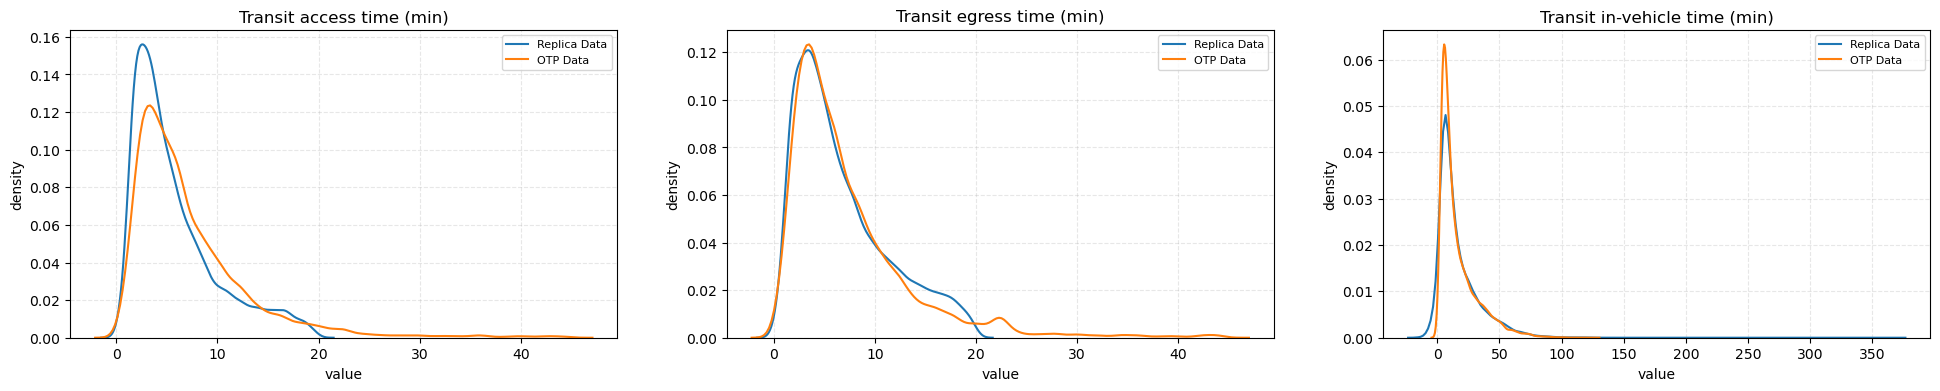

In [45]:
import seaborn as sns
from scipy.stats import gaussian_kde

condition = (check_peak['Access_time']!=20) & (check_peak['Egress_time']!=20)

fig,ax = plt.subplots(1,3,figsize=(24,4))
sns.kdeplot(check_peak.dropna(subset='Access_time')[condition]['Access_time'], bw_adjust=1, label='Replica Data' ,ax=ax[0])
sns.kdeplot(check_peak.dropna(subset='Access_time')[condition]['transit_at'], bw_adjust=1, label='OTP Data' ,ax=ax[0])
ax[0].legend(fontsize=8)
ax[0].grid(linestyle='--',alpha=0.3)
ax[0].set_title('Transit access time (min)')
ax[0].set_xlabel('value')
ax[0].set_ylabel('density')

sns.kdeplot(check_peak.dropna(subset='Egress_time')[condition]['Egress_time'], bw_adjust=1, label='Replica Data' ,ax=ax[1])
sns.kdeplot(check_peak.dropna(subset='Egress_time')[condition]['transit_et'], bw_adjust=1, label='OTP Data' ,ax=ax[1])
ax[1].legend(fontsize=8)
ax[1].grid(linestyle='--',alpha=0.3)
ax[1].set_title('Transit egress time (min)')
ax[1].set_xlabel('value')
ax[1].set_ylabel('density')

sns.kdeplot(check_peak.dropna(subset='In_vehicle_time')[condition]['In_vehicle_time'], bw_adjust=1, label='Replica Data' ,ax=ax[2])
sns.kdeplot(check_peak.dropna(subset='In_vehicle_time')[condition]['transit_ivt'], bw_adjust=1, label='OTP Data' ,ax=ax[2])
ax[2].legend(fontsize=8)
ax[2].grid(linestyle='--',alpha=0.3)
ax[2].set_title('Transit in-vehicle time (min)')
ax[2].set_xlabel('value')
ax[2].set_ylabel('density')

# sns.kdeplot(check_peak.dropna(subset='Total_Replica')[condition]['Total_Replica'], bw_adjust=1, label='Replica Data' ,ax=ax[3])
# sns.kdeplot(check_peak.dropna(subset='Total_Replica')[condition]['Total_OTP'], bw_adjust=1, label='OTP Data' ,ax=ax[3])
# ax[3].legend(fontsize=8)
# ax[3].grid(linestyle='--',alpha=0.3)
# ax[3].set_title('Total transit travel time (min)')
# ax[3].set_xlabel('value')
# ax[3].set_ylabel('density')

In [46]:
print('Avg access time (Replica):',check_peak.dropna(subset='Access_time')[condition]['Access_time'].mean())
print('Avg access time (OTP):',check_peak.dropna(subset='Access_time')[condition]['transit_at'].mean())

print('Avg egress time (Replica):',check_peak.dropna(subset='Egress_time')[condition]['Egress_time'].mean())
print('Avg egress time (OTP):',check_peak.dropna(subset='Egress_time')[condition]['transit_et'].mean())

print('Avg in-vehicle time (Replica):',check_peak.dropna(subset='In_vehicle_time')[condition]['In_vehicle_time'].mean())
print('Avg in-vehicle time (OTP):',check_peak.dropna(subset='In_vehicle_time')[condition]['transit_ivt'].mean())

print('Avg waiting time (OTP):',check_peak.dropna(subset='In_vehicle_time')[condition]['transit_wt'].mean())

print('Total transit travel time (Replica):',check_peak.dropna(subset='Total_Replica')[condition]['Total_Replica'].mean())
print('Total transit travel time (OTP):',check_peak.dropna(subset='Total_Replica')[condition]['Total_OTP'].mean())

Avg access time (Replica): 5.754520303639194
Avg access time (OTP): 7.220405292812302
Avg egress time (Replica): 6.7315860991682435
Avg egress time (OTP): 7.354763613565307
Avg in-vehicle time (Replica): 16.61590612520458
Avg in-vehicle time (OTP): 16.58422220572343
Avg waiting time (OTP): 5.114735483125861
Total transit travel time (Replica): 29.102012528012015
Total transit travel time (OTP): 36.274126595226896


Text(0, 0.5, 'density')

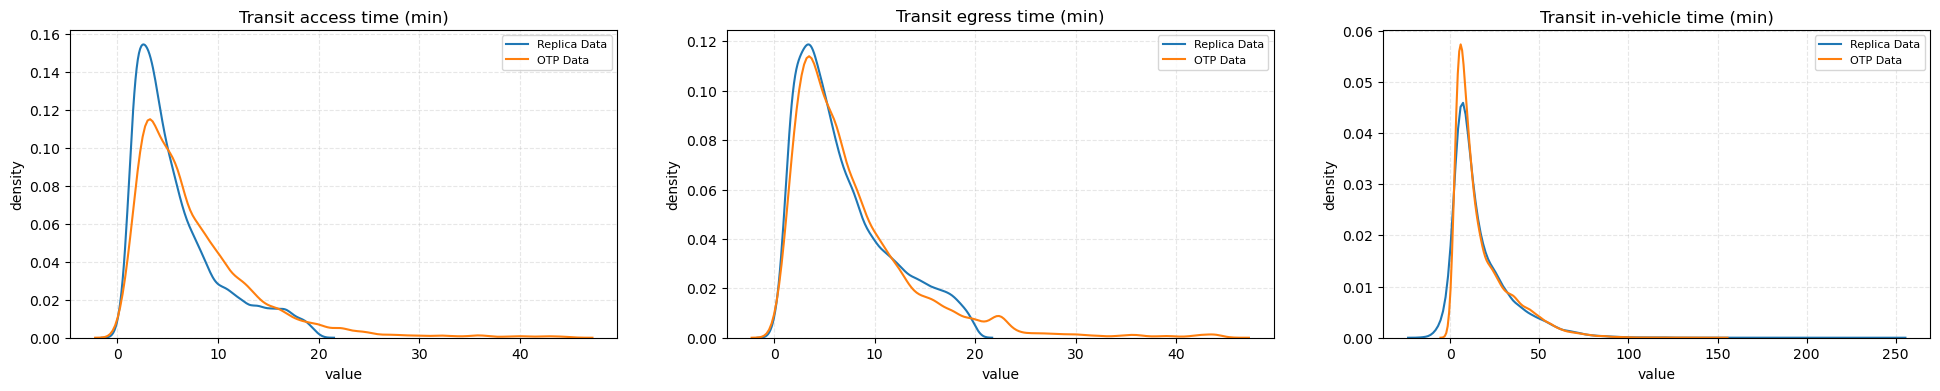

In [47]:
condition = (check_nonpeak['Access_time']!=20) & (check_nonpeak['Egress_time']!=20)

fig,ax = plt.subplots(1,3,figsize=(24,4))
sns.kdeplot(check_nonpeak.dropna(subset='Access_time')[condition]['Access_time'], bw_adjust=1, label='Replica Data' ,ax=ax[0])
sns.kdeplot(check_nonpeak.dropna(subset='Access_time')[condition]['transit_at'], bw_adjust=1, label='OTP Data' ,ax=ax[0])
ax[0].legend(fontsize=8)
ax[0].grid(linestyle='--',alpha=0.3)
ax[0].set_title('Transit access time (min)')
ax[0].set_xlabel('value')
ax[0].set_ylabel('density')

sns.kdeplot(check_nonpeak.dropna(subset='Egress_time')[condition]['Egress_time'], bw_adjust=1, label='Replica Data' ,ax=ax[1])
sns.kdeplot(check_nonpeak.dropna(subset='Egress_time')[condition]['transit_et'], bw_adjust=1, label='OTP Data' ,ax=ax[1])
ax[1].legend(fontsize=8)
ax[1].grid(linestyle='--',alpha=0.3)
ax[1].set_title('Transit egress time (min)')
ax[1].set_xlabel('value')
ax[1].set_ylabel('density')

sns.kdeplot(check_nonpeak.dropna(subset='In_vehicle_time')[condition]['In_vehicle_time'], bw_adjust=1, label='Replica Data' ,ax=ax[2])
sns.kdeplot(check_nonpeak.dropna(subset='In_vehicle_time')[condition]['transit_ivt'], bw_adjust=1, label='OTP Data' ,ax=ax[2])
ax[2].legend(fontsize=8)
ax[2].grid(linestyle='--',alpha=0.3)
ax[2].set_title('Transit in-vehicle time (min)')
ax[2].set_xlabel('value')
ax[2].set_ylabel('density')

# sns.kdeplot(check_nonpeak.dropna(subset='Total_Replica')[condition]['Total_Replica'], bw_adjust=1, label='Replica Data' ,ax=ax[3])
# sns.kdeplot(check_nonpeak.dropna(subset='Total_Replica')[condition]['Total_OTP'], bw_adjust=1, label='OTP Data' ,ax=ax[3])
# ax[3].legend(fontsize=8)
# ax[3].grid(linestyle='--',alpha=0.3)
# ax[3].set_title('Total transit travel time (min)')
# ax[3].set_xlabel('value')
# ax[3].set_ylabel('density')

In [48]:
def wavg(group, value_col, weight_col):
    """Return the weighted average of `value_col` using `weight_col`."""
    v = group[value_col]
    w = group[weight_col]
    return np.average(v, weights=w)

In [49]:
transit_agg = (check_peak
       .groupby(['origin_county', 'destination_county','Time_period'])
       .apply(lambda g: pd.Series({
           'OTP_transit_at': wavg(g, 'transit_at', 'Trip_num'),
           'OTP_transit_et': wavg(g, 'transit_et', 'Trip_num'),
           'OTP_transit_ivt': wavg(g, 'transit_ivt', 'Trip_num'),
           'OTP_transit_wt': wavg(g, 'transit_wt', 'Trip_num'),
           'OTP_transit_nt': wavg(g, 'transit_nt', 'Trip_num'),
           'OTP_transit_cost': wavg(g, 'cost', 'Trip_num'),
           'total_trips':      g['Trip_num'].sum()        # optional
       }))
       .reset_index())

transit_agg_dict = dict(tuple(transit_agg.groupby(['origin_county', 'destination_county','Time_period'])))

In [50]:
wt_factor = (check_peak['transit_wt']/check_peak[['transit_at','transit_ivt','transit_et']].sum(axis=1)).mean() # avg. waiting time / total travel time
print(wt_factor)

def OPT_transit_time_cost(record):
    # Only for transit
    if record['mode']=='transit':
        try:
            data = transit_agg_dict[(record['origin_county'],record['destination_county'],record['Time_period'])]
            values = data[['OTP_transit_at','OTP_transit_et','OTP_transit_wt','OTP_transit_ivt','OTP_transit_nt','OTP_transit_cost']].values[0]
            #values[2] = min(values[2],30)
            return pd.Series(values)
        except:
            wt = (record['transit_at']+record['transit_et']+record['transit_ivt'])*wt_factor
            return pd.Series([record['transit_at'],record['transit_et'],wt,record['transit_ivt'],record['transit_nt'],0])
    else:
        return pd.Series([0,0,0,0,0,0])

def add_tunnel_bridge_toll(record):
    if record['origin_county'][:2] in ['34'] and record['mode'] in ['driving','ondemand'] and record['destination_county'] in ['36061','36081','36047','36085','36005']:
        if record['Time_period']=='Overnight':
            return record['cost']+12.75
        else:
            return record['cost']+14.75
    elif record['origin_county'][:2] in ['34'] and record['mode'] in ['carpool'] and record['destination_county'] in ['36061','36081','36047','36085','36005']:
        if record['Time_period']=='Overnight':
            return record['cost']+12.75/2
        else:
            return record['cost']+14.75/2
    else:
        return record['cost']

def get_new_cost(record):
    if record['Pop_group']=='Senior':
        factor = 0.5
    else:
        factor = 1
    if record['mode']=='transit':
        if record['OTP_transit_cost']>0:
            return record['OTP_transit_cost'] * factor
        else:
            REGION_MAP = {"Manhattan": "NYC"} 
            FARE = {"NJS": 2.75, "NYS": 1.5, "NYC": 2.9, 'CTS': 1.5, 'PAS': 1.5}
            o = REGION_MAP.get(record["origin_region"], record["origin_region"])
            d = REGION_MAP.get(record["destination_region"], record["destination_region"])
            fare = sum([FARE[x] for x in set([o,d])])
            return fare * factor
    else:
        return record['cost']

0.14543765461445834


In [51]:
choice_data_new = choice_data_final.copy(deep=True)
# choice_data_new['cost'] = choice_data_new.apply(add_tunnel_bridge_toll,axis=1)
choice_data_new[['OTP_transit_at','OTP_transit_et','OTP_transit_wt','OTP_transit_ivt','OTP_transit_nt','OTP_transit_cost']] = choice_data_new.apply(OPT_transit_time_cost,axis=1)
choice_data_new['cost_new'] = choice_data_new.apply(get_new_cost,axis=1)

In [52]:
wt_factor = choice_data_new['OTP_transit_wt']/choice_data_new[['OTP_transit_at','OTP_transit_ivt','OTP_transit_et']].sum(axis=1)
wt_factor = wt_factor.fillna(0)
choice_data_new['transit_wt'] = choice_data_new[['transit_at','transit_ivt','transit_et']].sum(axis=1) * wt_factor

In [53]:
# Check transit waiting time
avg = choice_data_new[(choice_data_new['origin_region']=='Manhattan')&(choice_data_new['destination_region']=='Manhattan')&(choice_data_new['mode']=='transit')]['transit_wt'].mean()
print('Average transit waiting time from Manhattan to Manhattan: %.2f min'%avg)
avg = choice_data_new[(choice_data_new['origin_region']=='NYC')&(choice_data_new['destination_region']=='Manhattan')&(choice_data_new['mode']=='transit')]['transit_wt'].mean()
print('Average transit waiting time from NYC to Manhattan: %.2f min'%avg)
avg = choice_data_new[(choice_data_new['origin_region']=='NYS')&(choice_data_new['destination_region']=='Manhattan')&(choice_data_new['mode']=='transit')]['transit_wt'].mean()
print('Average transit waiting time from NY State to Manhattan: %.2f min'%avg)
avg = choice_data_new[(choice_data_new['origin_region']=='NJS')&(choice_data_new['destination_region']=='Manhattan')&(choice_data_new['mode']=='transit')]['transit_wt'].mean()
print('Average transit waiting time from NJ State to Manhattan: %.2f min'%avg)

Average transit waiting time from Manhattan to Manhattan: 2.01 min
Average transit waiting time from NYC to Manhattan: 6.86 min
Average transit waiting time from NY State to Manhattan: 19.97 min
Average transit waiting time from NJ State to Manhattan: 13.52 min


In [54]:
# Check transit waiting time
avg = choice_data_new[(choice_data_new['origin_region']=='Manhattan')&(choice_data_new['destination_region']=='Manhattan')&(choice_data_new['mode']=='transit')]['OTP_transit_wt'].mean()
print('Average transit waiting time from Manhattan to Manhattan: %.2f min'%avg)
avg = choice_data_new[(choice_data_new['origin_region']=='NYC')&(choice_data_new['destination_region']=='Manhattan')&(choice_data_new['mode']=='transit')]['OTP_transit_wt'].mean()
print('Average transit waiting time from NYC to Manhattan: %.2f min'%avg)
avg = choice_data_new[(choice_data_new['origin_region']=='NYS')&(choice_data_new['destination_region']=='Manhattan')&(choice_data_new['mode']=='transit')]['OTP_transit_wt'].mean()
print('Average transit waiting time from NY State to Manhattan: %.2f min'%avg)
avg = choice_data_new[(choice_data_new['origin_region']=='NJS')&(choice_data_new['destination_region']=='Manhattan')&(choice_data_new['mode']=='transit')]['OTP_transit_wt'].mean()
print('Average transit waiting time from NJ State to Manhattan: %.2f min'%avg)

Average transit waiting time from Manhattan to Manhattan: 2.36 min
Average transit waiting time from NYC to Manhattan: 7.13 min
Average transit waiting time from NY State to Manhattan: 19.91 min
Average transit waiting time from NJ State to Manhattan: 13.58 min


In [55]:
# Check transit cost
avg = choice_data_new[(choice_data_new['origin_region']=='Manhattan')&(choice_data_new['destination_region']=='Manhattan')&(choice_data_new['mode']=='transit')]['cost_new'].mean()
print('Average transit fare from Manhattan to Manhattan: $%.2f'%avg)
avg = choice_data_new[(choice_data_new['origin_region']=='NYC')&(choice_data_new['destination_region']=='Manhattan')&(choice_data_new['mode']=='transit')]['cost_new'].mean()
print('Average transit fare from NYC to Manhattan: $%.2f'%avg)
avg = choice_data_new[(choice_data_new['origin_region']=='NYS')&(choice_data_new['destination_region']=='Manhattan')&(choice_data_new['mode']=='transit')]['cost_new'].mean()
print('Average transit fare from NY State to Manhattan: $%.2f'%avg)
avg = choice_data_new[(choice_data_new['origin_region']=='NJS')&(choice_data_new['destination_region']=='Manhattan')&(choice_data_new['mode']=='transit')]['cost_new'].mean()
print('Average transit fare from NJ State to Manhattan: $%.2f'%avg)

Average transit fare from Manhattan to Manhattan: $2.56
Average transit fare from NYC to Manhattan: $2.82
Average transit fare from NY State to Manhattan: $4.09
Average transit fare from NJ State to Manhattan: $4.76


In [56]:
# Check trip volumn (to determine weights)
aa = choice_data_new.groupby(['origin_region','destination_region'])['Trip_num'].sum().reset_index().sort_values('Trip_num',ascending=False)
print('Total number of trips: ',aa['Trip_num'].sum())
aa.head()

Total number of trips:  70864699


,origin_region,destination_region,Trip_num
14,NJS,NJS,23193926
28,NYS,NYS,16342479
21,NYC,NYC,12897513
0,CTS,CTS,6594758
7,Manhattan,Manhattan,3614865


In [57]:
aa = choice_data_new.groupby(['origin_region','destination_region'])['Trip_num'].count().reset_index().sort_values('Trip_num',ascending=False)
aa.rename(columns={'Trip_num':'Number of OD pairs (samples)'},inplace=True)
print('Total number of samples: ',aa['Number of OD pairs (samples)'].sum())
aa.head()

Total number of samples:  46378


,origin_region,destination_region,Number of OD pairs (samples)
14,NJS,NJS,10143
28,NYS,NYS,3611
16,NJS,NYS,3560
26,NYS,NJS,3536
20,NYC,NJS,2985


In [58]:
choice_data_new.to_csv(root + '2.Joint mode and destination modeling/(1226) choice_dataset.csv',index=False)

### 5. Add region related interaction terms

In [103]:
choice_data = pd.read_csv(root + '2.Joint mode and destination modeling/(1226) choice_dataset.csv')

In [104]:
choice_data.columns[:30]

Index(['origin_county', 'Pop_group', 'Trip_purpose', 'Time_period',
       'destination_county', 'origin_region', 'destination_region', 'mode',
       'Trip_num', 'auto_tt', 'transit_ivt', 'transit_at', 'transit_et',
       'transit_nt', 'non_auto_tt', 'cost', 'constant_driving',
       'constant_transit', 'constant_ondemand', 'constant_biking',
       'constant_walking', 'constant_carpool', 'market_id', 'alternative_id',
       'All_trips', 'Trip_0', 'share', 'share_0', 'log_s_s0', 'log_s_s(mode)'],
      dtype='object')

In [105]:
choice_data['From_NYC'] = choice_data['origin_region'].isin(['NYC','Manhattan']).astype(int)
choice_data['To_NYC'] = choice_data['destination_region'].isin(['NYC','Manhattan']).astype(int)
choice_data['Is_NYC'] = choice_data['From_NYC'] * choice_data['To_NYC']
choice_data['F_T_NYC'] = (choice_data['origin_region'].isin(['NYC','Manhattan']) | choice_data['destination_region'].isin(['NYC','Manhattan'])).astype(int)

for column in ['cost_new_NYC','auto_tt_NYC','transit_at_NYC','transit_at_NYC','transit_et_NYC','transit_wt_NYC','transit_ivt_NYC','non_auto_tt_NYC']:
    choice_data[column] = choice_data[column[:-4]] * choice_data['From_NYC']

In [106]:
# choice_data.groupby(['Pop_group','Trip_purpose','Time_period'])['Trip_num'].sum().reset_index()

In [107]:
choice_data.to_csv(root + '2.Joint mode and destination modeling/(1226) choice_dataset.csv',index=False)

In [108]:
choice_data.columns

Index(['origin_county', 'Pop_group', 'Trip_purpose', 'Time_period',
       'destination_county', 'origin_region', 'destination_region', 'mode',
       'Trip_num', 'auto_tt', 'transit_ivt', 'transit_at', 'transit_et',
       'transit_nt', 'non_auto_tt', 'cost', 'constant_driving',
       'constant_transit', 'constant_ondemand', 'constant_biking',
       'constant_walking', 'constant_carpool', 'market_id', 'alternative_id',
       'All_trips', 'Trip_0', 'share', 'share_0', 'log_s_s0', 'log_s_s(mode)',
       'log_s_s(region)', 'log_s_s(county)', 'iv_auto_tt', 'iv_transit_ivt',
       'iv_nonauto_tt', 'County_09001', 'County_09005', 'County_09009',
       'County_34003', 'County_34013', 'County_34017', 'County_34019',
       'County_34021', 'County_34023', 'County_34025', 'County_34027',
       'County_34029', 'County_34031', 'County_34035', 'County_34037',
       'County_34039', 'County_36005', 'County_36027', 'County_36047',
       'County_36059', 'County_36061-0', 'County_36061-1', 'Co

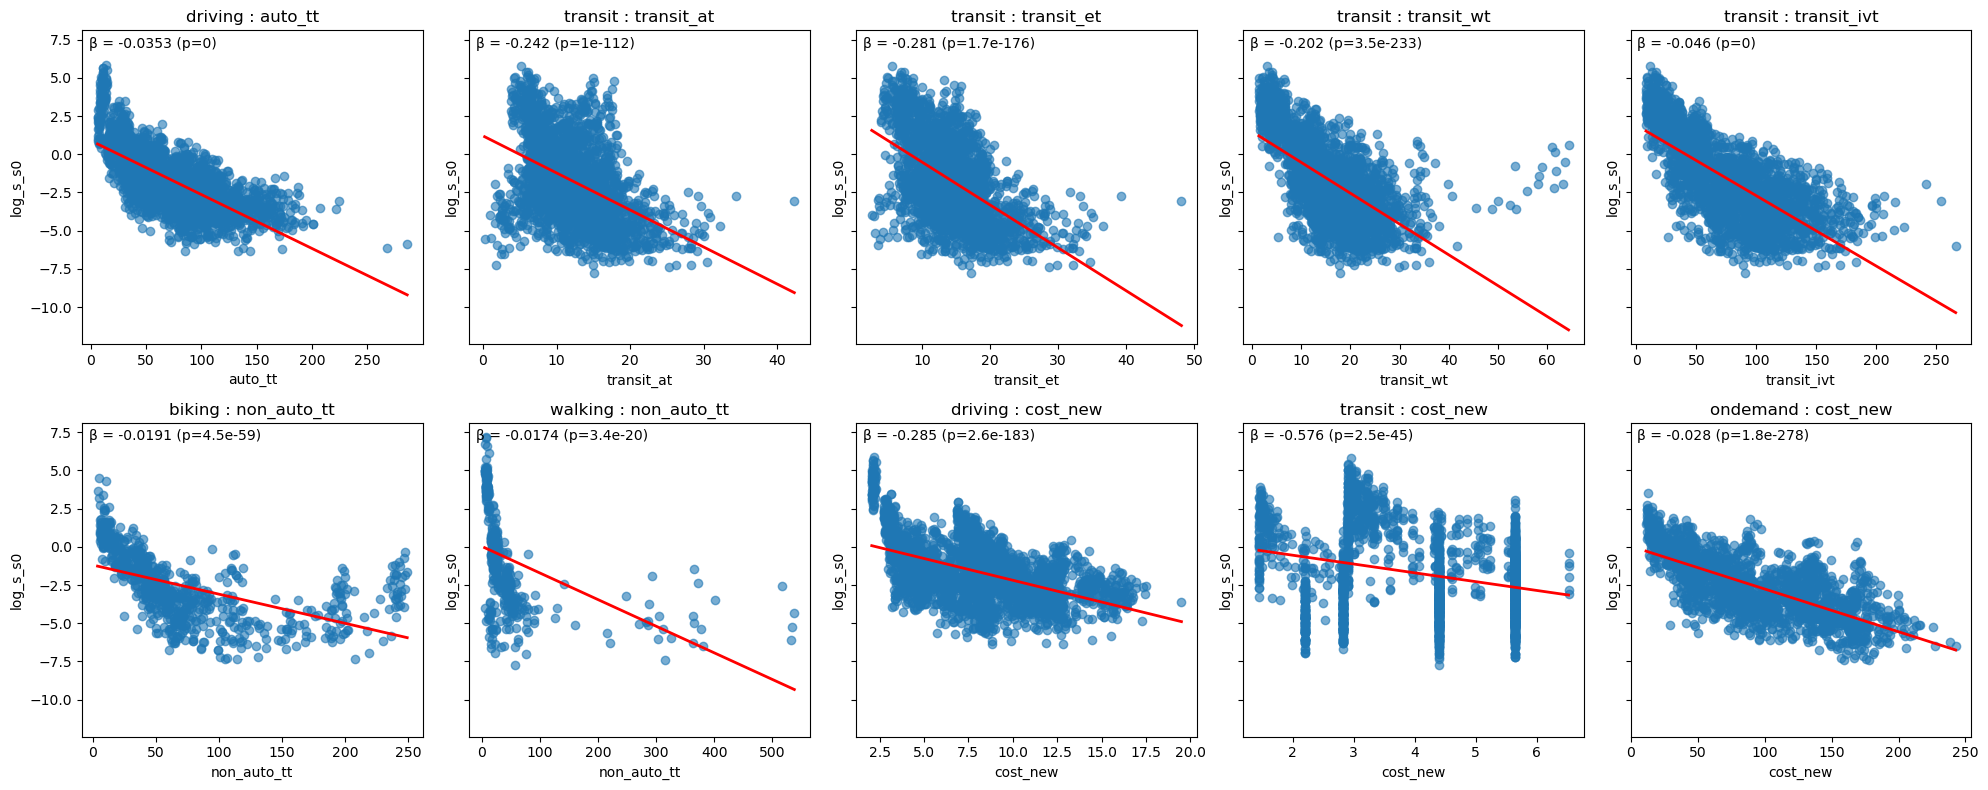

In [109]:
import statsmodels.api as sm

panels = [
    ('driving',   'auto_tt'),
    ('transit',   'transit_at'),
    ('transit',   'transit_et'),
    ('transit',   'transit_wt'),
    ('transit',   'transit_ivt'),
    ('biking',    'non_auto_tt'),
    ('walking',   'non_auto_tt'),
    ('driving', 'cost_new'),
    ('transit', 'cost_new'),
    ('ondemand', 'cost_new'),
]

yvar = 'log_s_s0'

fig, axes = plt.subplots(2, 5, figsize=(20, 8), sharey=True)
axes = axes.flatten()

for ax, (mode, xvar) in zip(axes, panels):
    df = choice_data.loc[(choice_data['mode'] == mode)&(choice_data['From_NYC'] == 1), [xvar, yvar]].dropna()

    # Guard against empty / tiny samples
    if df.shape[0] < 3:
        ax.set_title(f"{mode} : {xvar} (n<3)")
        ax.axis('off')
        continue

    x = df[xvar].to_numpy()
    y = df[yvar].to_numpy()

    # OLS: y = a + b x
    X = sm.add_constant(x)  # adds intercept
    model = sm.OLS(y, X).fit()
    a, b = model.params[0], model.params[1]
    r2 = model.rsquared
    n = df.shape[0]

    # Scatter
    ax.scatter(x, y, alpha=0.6)

    # Regression line over x-range
    xline = np.linspace(np.nanmin(x), np.nanmax(x), 100)
    yline = a + b * xline
    ax.plot(xline, yline, linewidth=2, color='red')

    # Labels / title
    ax.set_title(f"{mode} : {xvar}")
    ax.set_xlabel(xvar)
    ax.set_ylabel(yvar)

    # Annotation: coefficient + intercept + R^2 + n
    ax.text(
        0.02, 0.98,
        f"β = {b:.3g} (p={model.pvalues[1]:.2g})\n",
        transform=ax.transAxes,
        va='top',
        ha='left'
    )

plt.tight_layout()
plt.show()

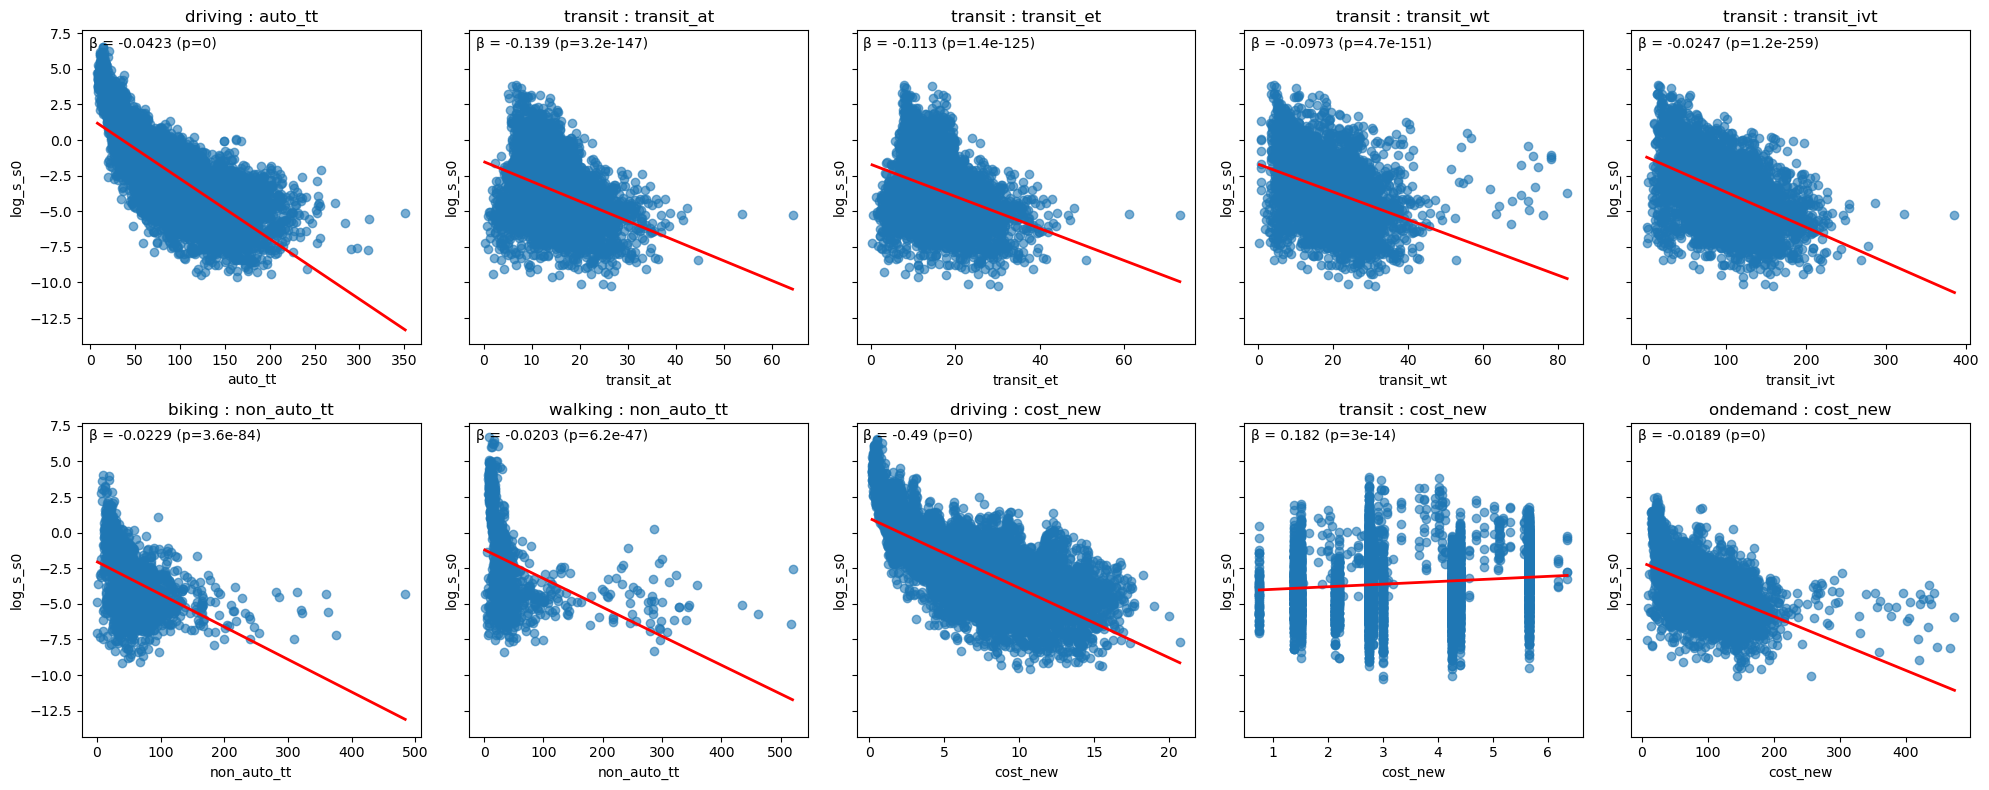

In [110]:
import statsmodels.api as sm

panels = [
    ('driving',   'auto_tt'),
    ('transit',   'transit_at'),
    ('transit',   'transit_et'),
    ('transit',   'transit_wt'),
    ('transit',   'transit_ivt'),
    ('biking',    'non_auto_tt'),
    ('walking',   'non_auto_tt'),
    ('driving', 'cost_new'),
    ('transit', 'cost_new'),
    ('ondemand', 'cost_new'),
]

yvar = 'log_s_s0'

fig, axes = plt.subplots(2, 5, figsize=(20, 8), sharey=True)
axes = axes.flatten()

for ax, (mode, xvar) in zip(axes, panels):
    df = choice_data.loc[(choice_data['mode'] == mode)&(choice_data['From_NYC'] == 0), [xvar, yvar]].dropna()

    # Guard against empty / tiny samples
    if df.shape[0] < 3:
        ax.set_title(f"{mode} : {xvar} (n<3)")
        ax.axis('off')
        continue

    x = df[xvar].to_numpy()
    y = df[yvar].to_numpy()

    # OLS: y = a + b x
    X = sm.add_constant(x)  # adds intercept
    model = sm.OLS(y, X).fit()
    a, b = model.params[0], model.params[1]
    r2 = model.rsquared
    n = df.shape[0]

    # Scatter
    ax.scatter(x, y, alpha=0.6)

    # Regression line over x-range
    xline = np.linspace(np.nanmin(x), np.nanmax(x), 100)
    yline = a + b * xline
    ax.plot(xline, yline, linewidth=2, color='red')

    # Labels / title
    ax.set_title(f"{mode} : {xvar}")
    ax.set_xlabel(xvar)
    ax.set_ylabel(yvar)

    # Annotation: coefficient + intercept + R^2 + n
    ax.text(
        0.02, 0.98,
        f"β = {b:.3g} (p={model.pvalues[1]:.2g})\n",
        transform=ax.transAxes,
        va='top',
        ha='left'
    )

plt.tight_layout()
plt.show()

### 6. Deal with extreme values

#### Modify

In [111]:
import numpy as np
import statsmodels.api as sm

panels = [
    ('driving',  'auto_tt'),
    ('transit',  'transit_at'),
    ('transit',  'transit_et'),
    ('transit',  'transit_wt'),
    ('transit',  'transit_ivt'),
    ('biking',   'non_auto_tt'),
    ('walking',  'non_auto_tt'),
    ('driving', 'cost_new'),
    ('ondemand', 'cost_new'),
    ('carpool', 'cost_new'),
]

yvar = 'log_s_s0'

# ---- thresholds by quantile ----
q = 0.99
thresholds = {}
for mode, xvar in panels:
    s = choice_data.loc[choice_data['mode'] == mode, xvar].dropna()
    thresholds[(mode, xvar)] = s.quantile(q) if len(s) else np.nan

# controls for randomness
noise_scale = 0.1
seed = 7
rng = np.random.default_rng(seed)

# slope tilt factor
tilt = 1

choice_data_modified = choice_data.copy()

for mode, xvar in panels:
    thr = thresholds.get((mode, xvar), np.nan)
    if not np.isfinite(thr):
        continue

    idx_mode = choice_data_modified.index[choice_data_modified['mode'] == mode]
    dfm = choice_data_modified.loc[idx_mode, [xvar, yvar]].dropna()

    if dfm.shape[0] < 10:
        continue

    fit_df = dfm[dfm[xvar] <= thr]
    if fit_df.shape[0] < 10:
        fit_df = dfm

    x = fit_df[xvar].to_numpy()
    y = fit_df[yvar].to_numpy()

    X = sm.add_constant(x)
    ols = sm.OLS(y, X).fit()
    a, b = ols.params

    # ---- ONLY change the slope if negative; keep intercept ----
    b_adj = tilt * b if (np.isfinite(b) and b < 0) else b

    if b_adj == 0 or not np.isfinite(b_adj):
        continue

    sigma_y = np.sqrt(ols.mse_resid) if np.isfinite(ols.mse_resid) else np.std(ols.resid)
    sigma_x = (sigma_y / abs(b_adj)) * noise_scale

    idx_hi = dfm.index[dfm[xvar] > thr]
    if len(idx_hi) == 0:
        continue

    y_hi = choice_data_modified.loc[idx_hi, yvar].to_numpy()

    # infer x from modified slope + original intercept
    x_hat = (y_hi - a) / b_adj
    x_new = x_hat + rng.normal(0.0, sigma_x, size=len(x_hat))
    x_new = np.clip(x_new, 0, thr)

    choice_data_modified.loc[idx_hi, xvar] = x_new


#### Check Results

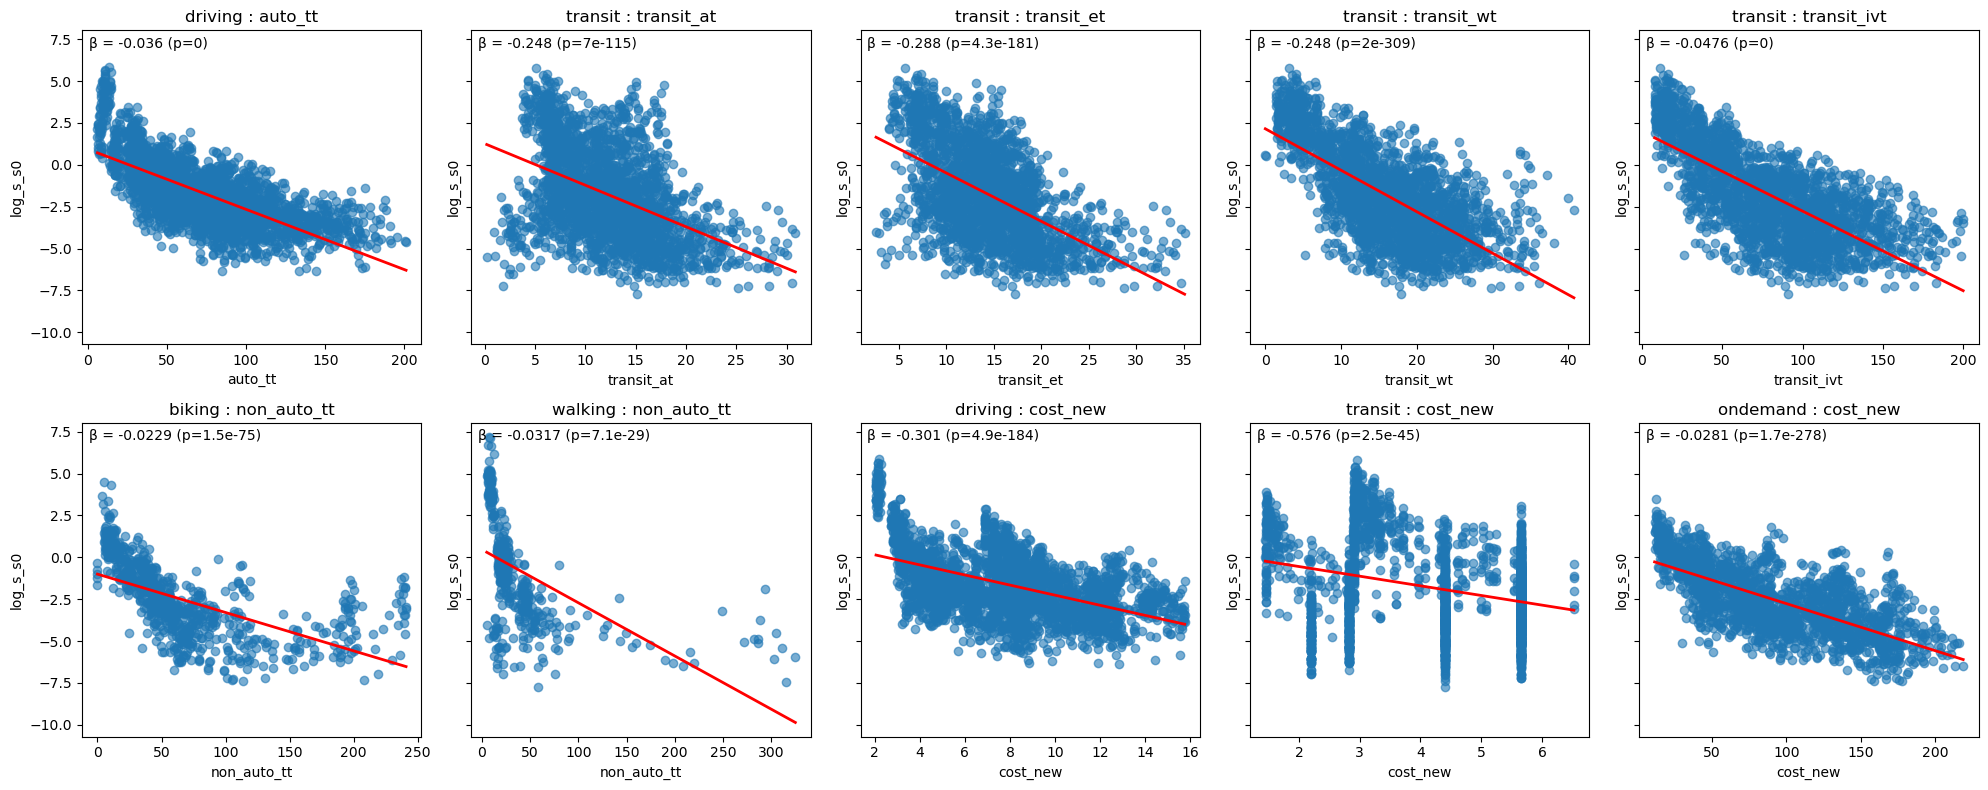

In [112]:
panels = [
    ('driving',   'auto_tt'),
    ('transit',   'transit_at'),
    ('transit',   'transit_et'),
    ('transit',   'transit_wt'),
    ('transit',   'transit_ivt'),
    ('biking',    'non_auto_tt'),
    ('walking',   'non_auto_tt'),
    ('driving', 'cost_new'),
    ('transit', 'cost_new'),
    ('ondemand', 'cost_new'),
]

yvar = 'log_s_s0'

fig, axes = plt.subplots(2, 5, figsize=(20, 8), sharey=True)
axes = axes.flatten()

for ax, (mode, xvar) in zip(axes, panels):
    df = choice_data_modified.loc[(choice_data_modified['mode'] == mode)&(choice_data_modified['From_NYC'] == 1), [xvar, yvar]].dropna()

    # Guard against empty / tiny samples
    if df.shape[0] < 3:
        ax.set_title(f"{mode} : {xvar} (n<3)")
        ax.axis('off')
        continue

    x = df[xvar].to_numpy()
    y = df[yvar].to_numpy()

    # OLS: y = a + b x
    X = sm.add_constant(x)  # adds intercept
    model = sm.OLS(y, X).fit()
    a, b = model.params[0], model.params[1]
    r2 = model.rsquared
    n = df.shape[0]

    # Scatter
    ax.scatter(x, y, alpha=0.6)

    # Regression line over x-range
    xline = np.linspace(np.nanmin(x), np.nanmax(x), 100)
    yline = a + b * xline
    ax.plot(xline, yline, linewidth=2, color='red')

    # Labels / title
    ax.set_title(f"{mode} : {xvar}")
    ax.set_xlabel(xvar)
    ax.set_ylabel(yvar)

    # Annotation: coefficient + intercept + R^2 + n
    ax.text(
        0.02, 0.98,
        f"β = {b:.3g} (p={model.pvalues[1]:.2g})\n",
        transform=ax.transAxes,
        va='top',
        ha='left'
    )

plt.tight_layout()
plt.show()

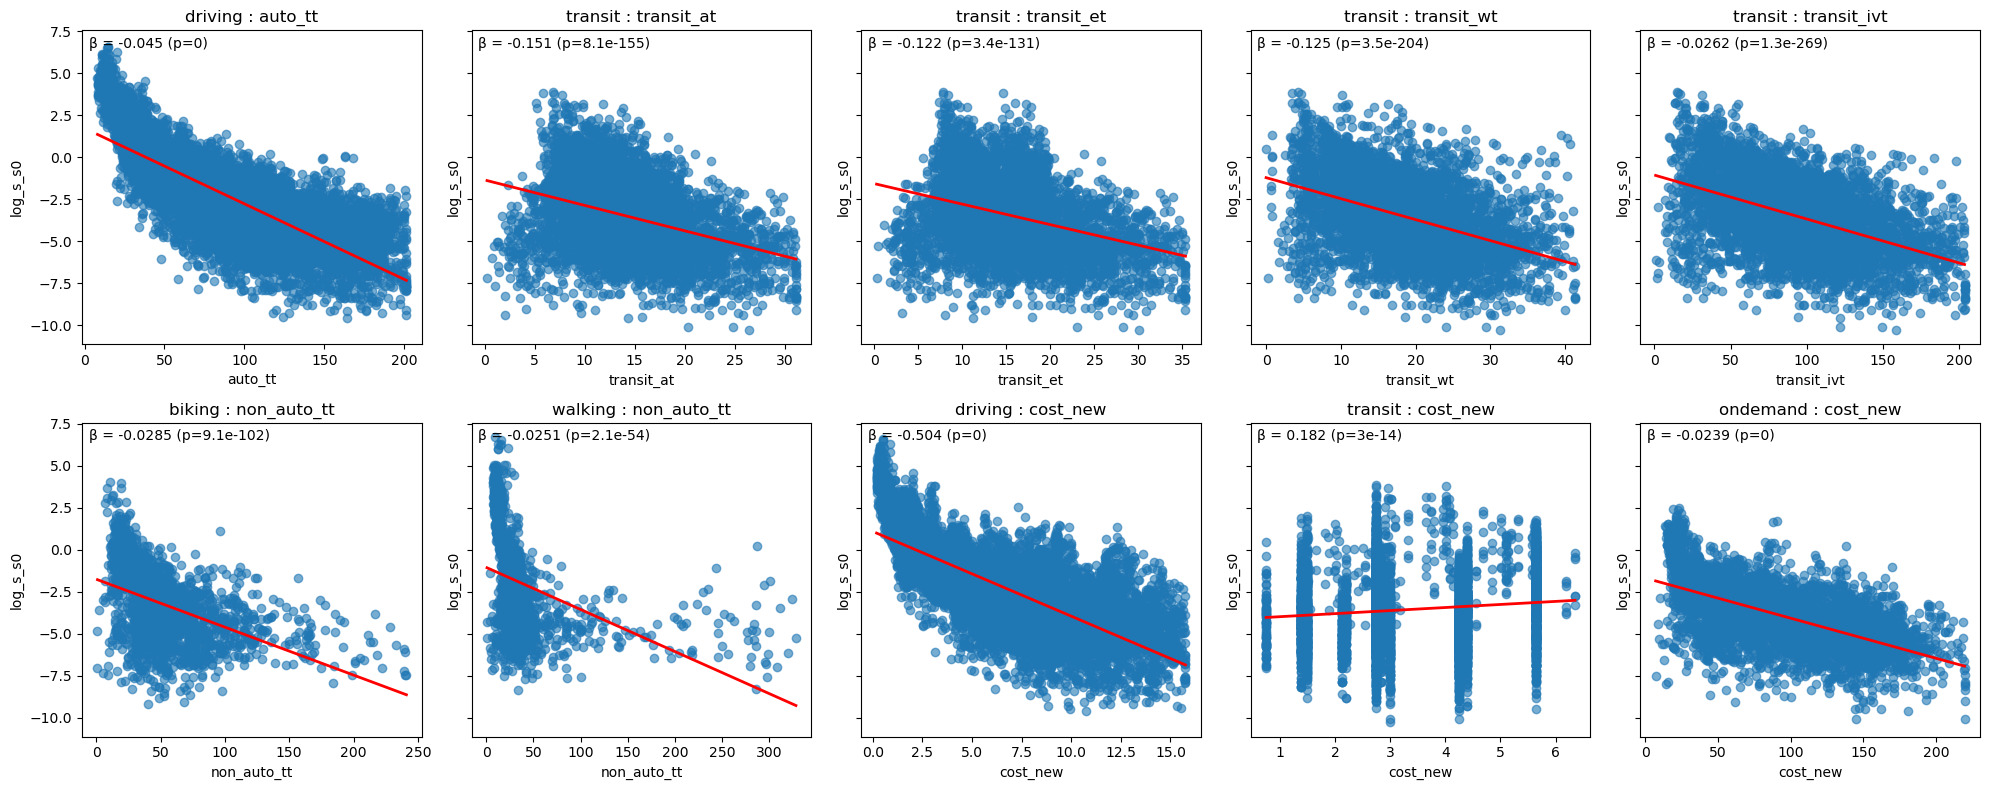

In [113]:
panels = [
    ('driving',   'auto_tt'),
    ('transit',   'transit_at'),
    ('transit',   'transit_et'),
    ('transit',   'transit_wt'),
    ('transit',   'transit_ivt'),
    ('biking',    'non_auto_tt'),
    ('walking',   'non_auto_tt'),
    ('driving', 'cost_new'),
    ('transit', 'cost_new'),
    ('ondemand', 'cost_new'),
]

yvar = 'log_s_s0'

fig, axes = plt.subplots(2, 5, figsize=(20, 8), sharey=True)
axes = axes.flatten()

for ax, (mode, xvar) in zip(axes, panels):
    df = choice_data_modified.loc[(choice_data_modified['mode'] == mode)&(choice_data_modified['From_NYC'] == 0), [xvar, yvar]].dropna()

    # Guard against empty / tiny samples
    if df.shape[0] < 3:
        ax.set_title(f"{mode} : {xvar} (n<3)")
        ax.axis('off')
        continue

    x = df[xvar].to_numpy()
    y = df[yvar].to_numpy()

    # OLS: y = a + b x
    X = sm.add_constant(x)  # adds intercept
    model = sm.OLS(y, X).fit()
    a, b = model.params[0], model.params[1]
    r2 = model.rsquared
    n = df.shape[0]

    # Scatter
    ax.scatter(x, y, alpha=0.6)

    # Regression line over x-range
    xline = np.linspace(np.nanmin(x), np.nanmax(x), 100)
    yline = a + b * xline
    ax.plot(xline, yline, linewidth=2, color='red')

    # Labels / title
    ax.set_title(f"{mode} : {xvar}")
    ax.set_xlabel(xvar)
    ax.set_ylabel(yvar)

    # Annotation: coefficient + intercept + R^2 + n
    ax.text(
        0.02, 0.98,
        f"β = {b:.3g} (p={model.pvalues[1]:.2g})\n",
        transform=ax.transAxes,
        va='top',
        ha='left'
    )

plt.tight_layout()
plt.show()

In [114]:
for column in ['cost_new_NYC','auto_tt_NYC','transit_at_NYC','transit_at_NYC','transit_et_NYC','transit_wt_NYC','transit_ivt_NYC','non_auto_tt_NYC']:
    choice_data_modified[column] = choice_data_modified[column[:-4]] * choice_data_modified['From_NYC']

In [115]:
choice_data_modified.to_csv(root + '2.Joint mode and destination modeling/(1226) choice_dataset_v2.csv',index=False)